## Project 4 
### steps
1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [225]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from glob import glob
%matplotlib inline

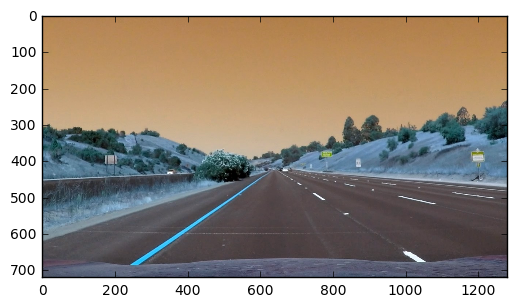

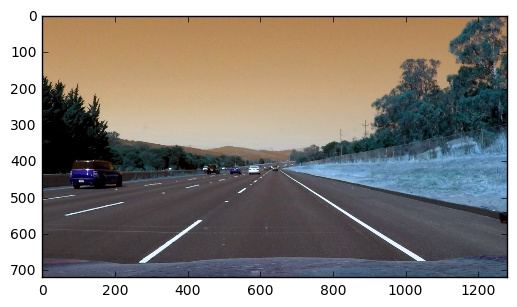

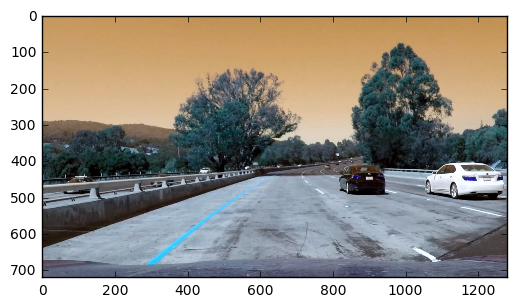

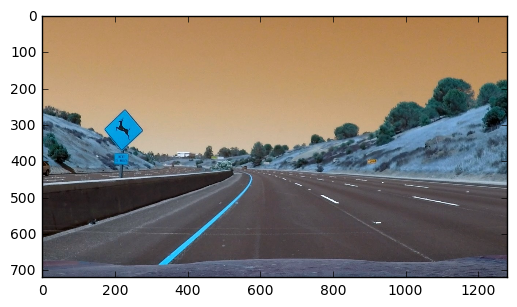

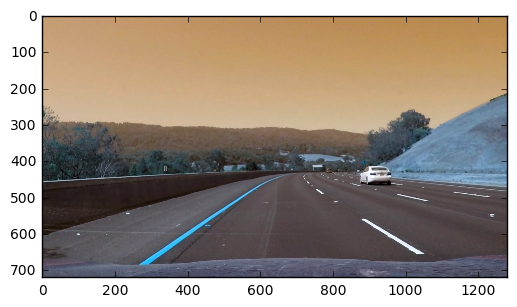

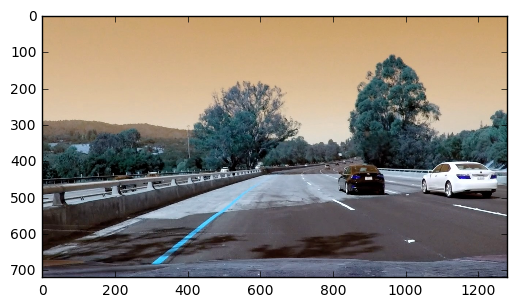

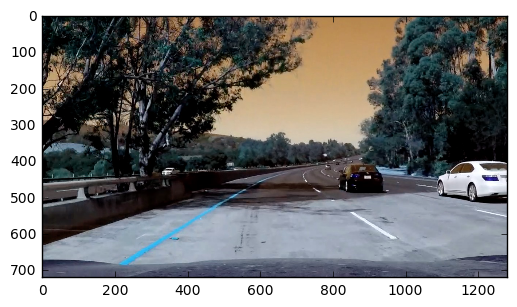

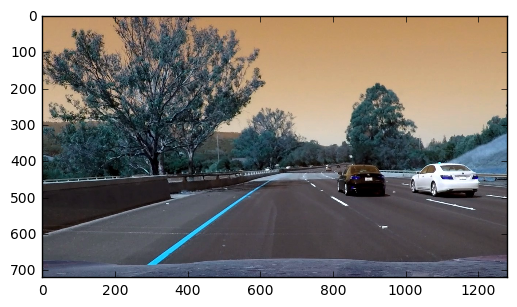

In [226]:
files = glob('test_images/*.jpg') 
for file in files:
    img = cv2.imread(file)
    plt.figure()
    plt.imshow(img)
plt.show()

In [227]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [426]:
class preprocess_pipeline(object):
    def __init__(self, calib_images_location, input_img=None):
        self.calib_images_location = calib_images_location
        self.camera_mtx = []
        self.dtx_mtx = []
        self.persp_mtx = []
        self.inv_persp_mtx = []
        self.img_array = [] #list of images with the latest image 
        
        self.kernel_size = 15
        self.sobel_x_thresh = (30, 255)
        self.sobel_y_thresh = (30, 255)
        self.sobel_mag_thresh = (30, 255)
        self.sobel_dir_thresh = (0.3,1.3)
        
        if input_img:
            self.img_array.append(input_img)
        
        
    def camera_calib(self, plot_stuff=False):
        print("Pipeline: Camera Calibration in progress...")
        obj_points = []
        img_points = []
        #setup object points for 9x6 checkerboard
        objp = np.zeros((6*9,3), np.float32)
        objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

        calib_images = glob(self.calib_images_location + '/calib*.jpg')
        for image in calib_images:
            img = cv2.imread(image)
            gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
            if ret:
                img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
                img_points.append(corners)
                obj_points.append(objp)
                if plot_stuff:
                    plt.figure()
                    plt.imshow(img)
        ret, c_mtx, dist_mtx, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, gray.shape[::-1], None, None)
        self.camera_mtx = c_mtx
        self.dtx_mtx = dist_mtx
        return c_mtx, dist_mtx, rvecs, tvecs
    
    #distortion correction
    def dtx_correction(self,input_image):
        print("Pipeline: Performing distortion correction...")
        undtx_image = cv2.undistort(img, self.camera_mtx, self.dtx_mtx)
        if self.img_array:
            self.img_array.append(undtx_image)
        else:
            self.img_array.append(input_image)
            self.img_array.append(undtx_image)
        return undtx_image
    
    def apply_sobel(self, input_image, kernel_size=3):
        print("Pipeline: applying sobel operator with kernel size" + str(kernel_size) + "...")
        gray = cv2.cvtColor(input_image, cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel_size)
        abs_sobelx = np.absolute(sobelx) + 0.5
        abs_sobely = np.absolute(sobely) + 0.5
        abs_sobel_mag = np.sqrt((abs_sobelx**2) + (abs_sobely**2))
        abs_sobel_dir = np.arctan(abs_sobely/abs_sobelx)
            
        sobel_gradient_dict = {'sobel_x': np.uint8(255*abs_sobelx/np.max(abs_sobelx)),
                                 'sobel_y': np.uint8(255*abs_sobely/np.max(abs_sobely)),
                                 'sobel_mag': np.uint8(255*abs_sobel_mag/np.max(abs_sobel_mag)),
                                 'sobel_dir': abs_sobel_dir}

        return sobel_gradient_dict
    
    def apply_sobel_thresh(self, sobel_dict, x_thresh, y_thresh, mag_thresh, dir_thresh):
        print("Pipeline: computing sobel...")
        sxbinary = np.zeros_like(list(sobel_dict.values())[1])
        sxbinary[(sobel_dict['sobel_x'] >= x_thresh[0]) & (sobel_dict['sobel_x'] <= x_thresh[1])
                  | (sobel_dict['sobel_y'] >= y_thresh[0]) & (sobel_dict['sobel_y'] <= y_thresh[0])
                  | (sobel_dict['sobel_mag'] >= mag_thresh[0]) & (sobel_dict['sobel_mag'] <= mag_thresh[0]) 
                  | (sobel_dict['sobel_dir'] >= dir_thresh[0]) & (sobel_dict['sobel_dir'] <= dir_thresh[0]) 
                 ] = 1
        return sxbinary
    
    def apply_s_channel_thresh(self, input_img, thresh):
        print("Pipeline: applying thresholding operator...")
        hls = cv2.cvtColor(input_img, cv2.COLOR_RGB2HLS)
        s_channel = hls[:,:,2]
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
        return s_binary
    
    def apply_perspective_transform(self, input_img):
        print("Pipeline: performing perspective transform...")
        (h, w) = (720, 1280)
        dst = np.float32([[250, 0],[850, 0], [250, h],[850, h] ])
        src = np.float32([[550,500], [800,500], [250, h], [1200,h]])
        img_size = (w,h)
        
        self.persp_mtx = cv2.getPerspectiveTransform(src, dst)
        self.inv_persp_mtx = cv2.getPerspectiveTransform(dst, src)
        warped = cv2.warpPerspective(input_img, self.persp_mtx, img_size, flags=cv2.INTER_LINEAR) 
        return warped
        
    def fit_lane_lines(self,binary_warped):
        histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        return out_img, left_fit, right_fit, ploty, left_lane_inds, right_lane_inds
    
    def fit_lane_next(self,binary_warped, left_fit, right_fit):
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

         #get lane curvature

        y_eval = np.max(np.concatenate((lefty, righty), axis=0))
        left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
        right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters

        return left_fitx, right_fitx, ploty, left_lane_inds, right_lane_inds, left_curverad, right_curverad
    

    def draw_lane(self, warped,undist, left_fitx, right_fitx, ploty, left_curvature, right_curvature):
    # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, self.inv_persp_mtx, (warped.shape[1], warped.shape[0])) 
        # Combine the result with the original image

        result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
        image_txt = "left_curve=" + "%.2f" % (left_curvature) + " right_curve=" + "%.2f" % (left_curvature)
        result = cv2.putText(result,image_txt, (150,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),2)
        return result
    
    def overlay_lane(self,binary_warped, left_fitx, right_fitx, left_lane_ids, right_lane_ids):
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)

        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)

        return result
    
    def set_params(self):
        print("setting kernel size and sobel params")
        self.kernel_size = 15
        self.sobel_x_thresh = (30, 255)
        self.sobel_y_thresh = (30, 255)
        self.sobel_mag_thresh = (30, 255)
        self.sobel_dir_thresh = (0.3,1.3)
    
    def process_frame(self,frame):
        print("processing new frame")
        undtx_img = self.dtx_correction(frame)
        sobel_dict = self.apply_sobel(undtx_img, kernel_size)
        sobel_thresh = self.apply_sobel_thresh(sobel_dict, self.sobel_x_thresh, self.sobel_y_thresh, 
                                               self.sobel_mag_thresh, self.sobel_dir_thresh)
        s_channel = self.apply_s_channel_thresh(undtx_img, (170,255))
        full_image = sobel_thresh | s_channel

        perspective = self.apply_perspective_transform(full_image)
        out_img, left_fit, right_fit, lane_y, left_lane_inds, right_lane_inds = self.fit_lane_lines(perspective)
        left_fit, right_fit, ploty, left_lane_inds, right_lane_inds, left_cr, right_cr = self.fit_lane_next(perspective, left_fit, right_fit)
        final_result = self.draw_lane(perspective,undtx_img, left_fit, right_fit, ploty, left_cr, right_cr) 
        return final_result

        



In [419]:
pp = preprocess_pipeline('camera_cal')
c_mtx, dist_mtx, rvecs, tvecs = pp.camera_calib()

Pipeline: Camera Calibration in progress...


Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size15...
0.5
4618874125.5
Pipeline: computing sobel...
255
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
(720, 1280, 3)
(720, 1280, 3)


/Users/farhan/anaconda/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:99: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


17111.87716 m 10590.478196 m


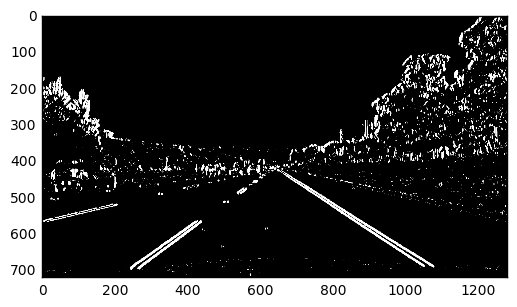

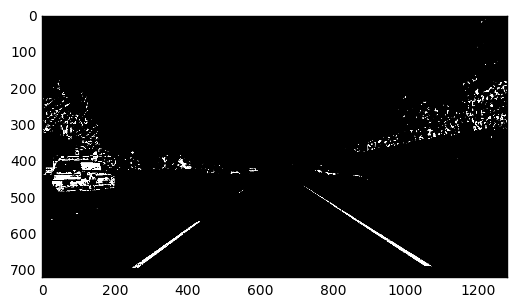

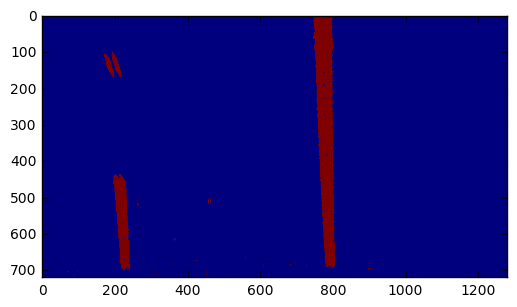

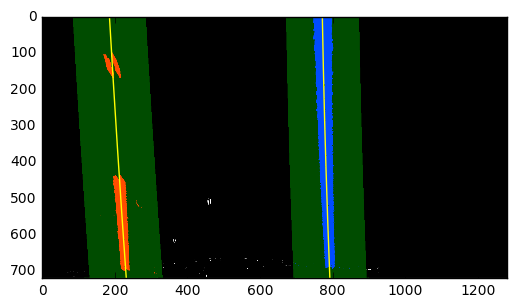

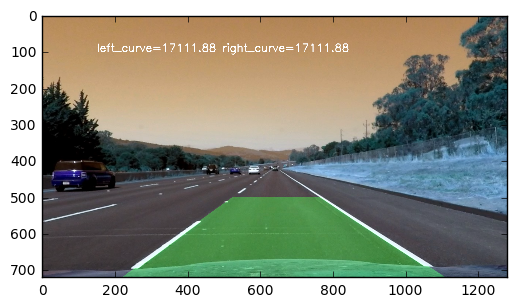

In [413]:
#Try all steps on a single image
kernel_size = 15

test_images = glob('test_images/*.jpg')
img = cv2.imread(test_images[1])
undtx_img = pp.dtx_correction(img)
sobel_dict = pp.apply_sobel(undtx_img, kernel_size)
sobel_x_thresh = (30, 255)
sobel_y_thresh = (30, 255)
sobel_mag_thresh = (30, 255)
sobel_dir_thresh = (0.3,1.3)
sobel_img = pp.apply_sobel_thresh(sobel_dict, sobel_x_thresh, sobel_y_thresh, sobel_mag_thresh, sobel_dir_thresh)

plt.figure()
plt.imshow(sobel_img, cmap='gray')

s_channel = pp.apply_s_channel_thresh(undtx_img, (170,255))
plt.figure()
plt.imshow(s_channel, cmap='gray')

full_image = sobel_thresh | s_channel
perspective = pp.apply_perspective_transform(full_image)

plt.figure()
plt.imshow(perspective)
out_img, left_fit, right_fit, lane_y, left_lane_inds, right_lane_inds = pp.fit_lane_lines(perspective)
print(out_img.shape)
plt.figure()
plt.imshow(out_img)
left_fit, right_fit, ploty, left_lane_inds, right_lane_inds, left_cr, right_cr = pp.fit_lane_next(perspective, left_fit, right_fit)
pp.overlay_lane(perspective, left_fit, right_fit, left_lane_inds, right_lane_inds)

final_result = pp.draw_lane(perspective,undtx_img, left_fit, right_fit, ploty, left_cr, right_cr)
plt.figure()
plt.imshow(final_result)



Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
0.5
8074.5
Pipeline: computing sobel...
255
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


/Users/farhan/anaconda/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:99: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(720, 1280, 3)
9190.99011039 m 10978.0870298 m
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
0.5
8463.5
Pipeline: computing sobel...
255
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
(720, 1280, 3)
17111.87716 m 10590.478196 m
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
0.5
9904.5
Pipeline: computing sobel...
255
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
(720, 1280, 3)
3812.54826173 m 2936.80093903 m
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
0.5
6479.5
Pipeline: computing sobel...
255
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
(720, 1280, 3)
3268.14179625 m 5021.9687374 m
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
0.5
7142.5

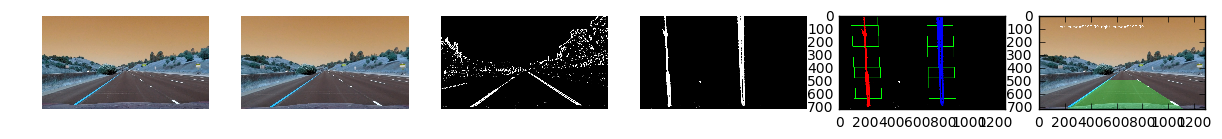

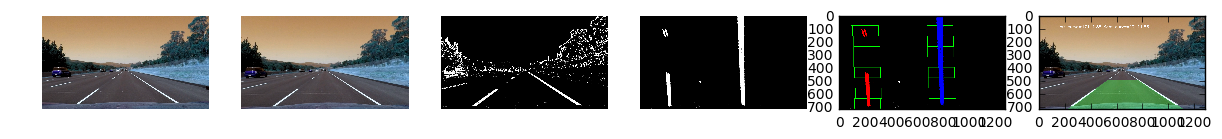

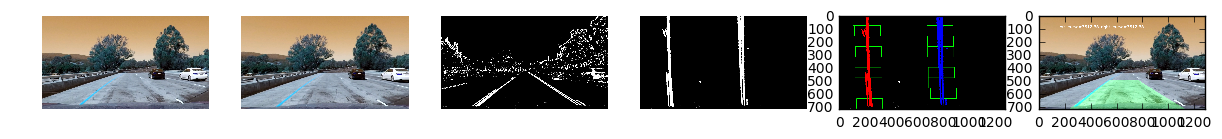

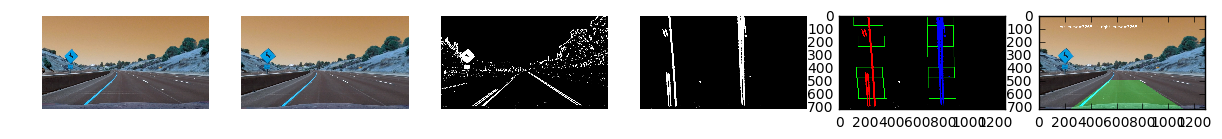

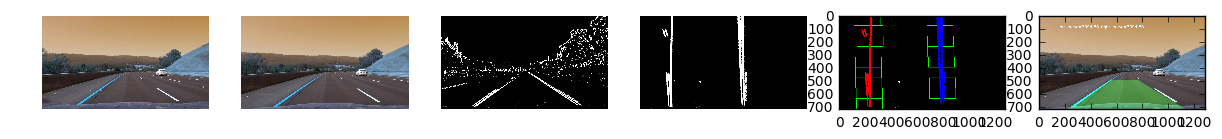

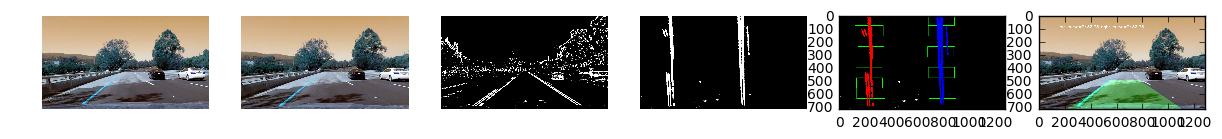

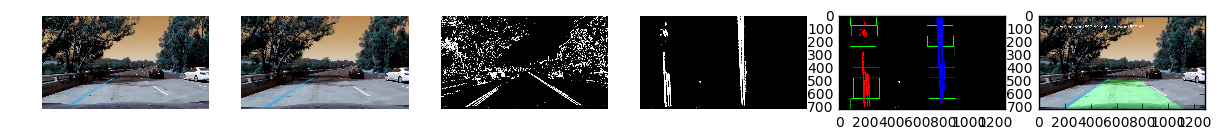

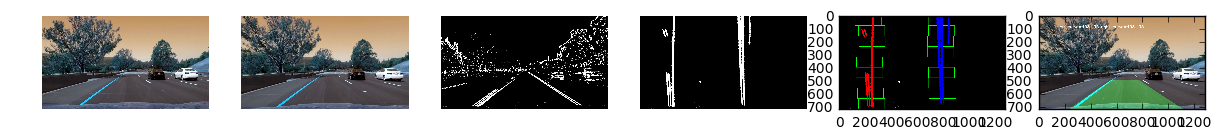

In [415]:
kernel_size = 5
sobel_min = 40
sobel_max = 150

n_col = 6
for image_file in glob('test_images/*.jpg'):
    img = cv2.imread(image_file)
    undtx_img = pp.dtx_correction(img)
    
    sobel_img = pp.apply_sobel(undtx_img, kernel_size)
    sobel_thresh = pp.apply_sobel_thresh(sobel_dict, sobel_x_thresh, sobel_y_thresh, sobel_mag_thresh, sobel_dir_thresh)
    s_channel = pp.apply_s_channel_thresh(undtx_img, (170,255))
    full_image = sobel_thresh | s_channel
    
    perspective = pp.apply_perspective_transform(full_image)
    out_img, left_fit, right_fit, lane_y, left_lane_inds, right_lane_inds = pp.fit_lane_lines(perspective)
    left_fit, right_fit, ploty, left_lane_inds, right_lane_inds, left_cr, right_cr = pp.fit_lane_next(perspective, left_fit, right_fit)
    final_result = pp.draw_lane(perspective,undtx_img, left_fit, right_fit, ploty, left_cr, right_cr) 

    
    fig = plt.figure(figsize=(15,15))
    
    ax = fig.add_subplot(1,n_col,1)
    plot_img = img
    ax.imshow(plot_img, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1,n_col,2)
    plot_img = undtx_img
    plt.imshow(plot_img, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1,n_col,3)
    plot_img = full_image
    plt.imshow(plot_img, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1,n_col,4)
    plot_img = perspective
    plt.imshow(plot_img, cmap='gray')
    plt.axis('off')

    plt.subplot(1, n_col, 5)
    plot_img = out_img
    plt.imshow(plot_img, cmap='gray')
    
    plt.subplot(1, n_col, 6)
    plot_img = final_result    
    plt.imshow(plot_img)
    
    

Pipeline: Camera Calibration in progress...
setting kernel size and sobel params
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


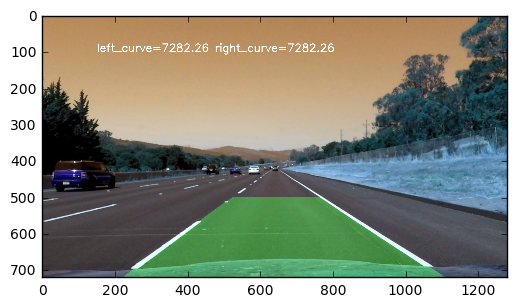

In [427]:
pp_video = preprocess_pipeline('camera_cal')
c_mtx, dist_mtx, rvecs, tvecs = pp_video.camera_calib()
pp_video.set_params()

test_images = glob('test_images/*.jpg')
img = cv2.imread(test_images[1])

result = pp_video.process_frame(img)
plt.imshow(result)

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


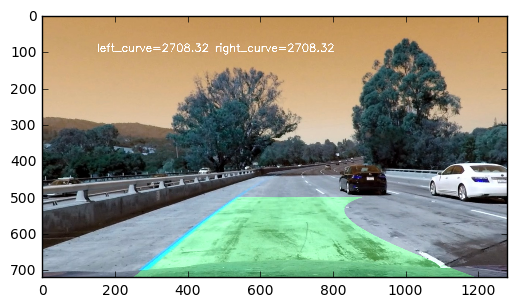

In [428]:
img = cv2.imread(test_images[2])

result = pp_video.process_frame(img)
plt.imshow(result)

In [ ]:
from moviepy.editor import VideoFileClip

white_output = 'project_video_labelled.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pp_video.process_frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
[MoviePy] >>>> Building video project_video_labelled.mp4
[MoviePy] Writing video project_video_labelled.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


  0%|          | 1/1261 [00:00<07:08,  2.94it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


  0%|          | 2/1261 [00:00<06:52,  3.05it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


  0%|          | 3/1261 [00:00<06:28,  3.24it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


  0%|          | 4/1261 [00:01<06:11,  3.38it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


  0%|          | 5/1261 [00:01<05:59,  3.49it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


  0%|          | 6/1261 [00:01<05:53,  3.55it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


  1%|          | 7/1261 [00:01<05:51,  3.57it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


  1%|          | 8/1261 [00:02<05:42,  3.66it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


  1%|          | 9/1261 [00:02<05:36,  3.73it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


  1%|          | 10/1261 [00:02<05:44,  3.63it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


  1%|          | 11/1261 [00:03<05:45,  3.62it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


  1%|          | 12/1261 [00:03<05:41,  3.66it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


  1%|          | 13/1261 [00:03<06:47,  3.06it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


  1%|          | 14/1261 [00:04<08:33,  2.43it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  1%|          | 15/1261 [00:04<08:40,  2.40it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  1%|▏         | 16/1261 [00:05<07:40,  2.70it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  1%|▏         | 17/1261 [00:05<06:55,  2.99it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  1%|▏         | 18/1261 [00:05<06:33,  3.16it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  2%|▏         | 19/1261 [00:05<06:32,  3.16it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  2%|▏         | 20/1261 [00:06<06:12,  3.33it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  2%|▏         | 21/1261 [00:06<05:53,  3.51it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  2%|▏         | 22/1261 [00:06<06:00,  3.44it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  2%|▏         | 23/1261 [00:07<05:57,  3.46it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  2%|▏         | 24/1261 [00:07<05:49,  3.54it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  2%|▏         | 25/1261 [00:07<05:39,  3.64it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  2%|▏         | 26/1261 [00:07<05:33,  3.70it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  2%|▏         | 27/1261 [00:08<05:27,  3.77it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  2%|▏         | 28/1261 [00:08<05:25,  3.78it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  2%|▏         | 29/1261 [00:08<05:22,  3.83it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  2%|▏         | 30/1261 [00:08<05:27,  3.75it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


  2%|▏         | 31/1261 [00:09<07:06,  2.88it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  3%|▎         | 32/1261 [00:09<07:37,  2.68it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  3%|▎         | 33/1261 [00:10<08:34,  2.39it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  3%|▎         | 34/1261 [00:10<09:00,  2.27it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  3%|▎         | 35/1261 [00:11<09:37,  2.12it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


  3%|▎         | 36/1261 [00:11<08:25,  2.42it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


  3%|▎         | 37/1261 [00:11<07:27,  2.73it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


  3%|▎         | 38/1261 [00:12<06:53,  2.96it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...


  3%|▎         | 39/1261 [00:12<06:43,  3.03it/s]

Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  3%|▎         | 40/1261 [00:12<06:21,  3.20it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  3%|▎         | 41/1261 [00:13<06:00,  3.39it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  3%|▎         | 42/1261 [00:13<05:49,  3.49it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  3%|▎         | 43/1261 [00:13<05:46,  3.51it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  3%|▎         | 44/1261 [00:13<05:35,  3.63it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  4%|▎         | 45/1261 [00:14<05:27,  3.71it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  4%|▎         | 46/1261 [00:14<05:21,  3.78it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  4%|▎         | 47/1261 [00:14<05:21,  3.78it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  4%|▍         | 48/1261 [00:14<05:20,  3.79it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  4%|▍         | 49/1261 [00:15<05:24,  3.74it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  4%|▍         | 50/1261 [00:15<05:22,  3.75it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  4%|▍         | 51/1261 [00:15<05:20,  3.78it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  4%|▍         | 52/1261 [00:15<05:19,  3.79it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  4%|▍         | 53/1261 [00:16<05:19,  3.78it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  4%|▍         | 54/1261 [00:16<05:17,  3.80it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  4%|▍         | 55/1261 [00:16<05:17,  3.80it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  4%|▍         | 56/1261 [00:16<05:19,  3.77it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  5%|▍         | 57/1261 [00:17<05:24,  3.71it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  5%|▍         | 58/1261 [00:17<06:30,  3.08it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...


  5%|▍         | 59/1261 [00:18<06:55,  2.89it/s]

Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  5%|▍         | 60/1261 [00:18<06:55,  2.89it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  5%|▍         | 61/1261 [00:18<07:53,  2.54it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


  5%|▍         | 62/1261 [00:19<07:05,  2.82it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


  5%|▍         | 63/1261 [00:19<06:39,  3.00it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


  5%|▌         | 64/1261 [00:19<06:33,  3.04it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


  5%|▌         | 65/1261 [00:20<06:12,  3.21it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  5%|▌         | 66/1261 [00:20<07:22,  2.70it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


  5%|▌         | 67/1261 [00:20<07:19,  2.72it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  5%|▌         | 68/1261 [00:21<08:39,  2.29it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


  5%|▌         | 69/1261 [00:21<07:54,  2.51it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


  6%|▌         | 70/1261 [00:22<07:07,  2.79it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  6%|▌         | 71/1261 [00:22<06:56,  2.86it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  6%|▌         | 72/1261 [00:22<06:21,  3.11it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  6%|▌         | 73/1261 [00:22<06:00,  3.30it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  6%|▌         | 74/1261 [00:23<05:46,  3.43it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  6%|▌         | 75/1261 [00:23<05:33,  3.56it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  6%|▌         | 76/1261 [00:23<05:27,  3.61it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  6%|▌         | 77/1261 [00:24<05:23,  3.66it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  6%|▌         | 78/1261 [00:24<05:18,  3.72it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  6%|▋         | 79/1261 [00:24<05:17,  3.73it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  6%|▋         | 80/1261 [00:24<05:15,  3.75it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  6%|▋         | 81/1261 [00:25<05:51,  3.35it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  7%|▋         | 82/1261 [00:25<07:05,  2.77it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


  7%|▋         | 83/1261 [00:25<06:29,  3.02it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


  7%|▋         | 84/1261 [00:26<06:22,  3.08it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


  7%|▋         | 85/1261 [00:26<06:06,  3.21it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  7%|▋         | 86/1261 [00:27<06:53,  2.84it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  7%|▋         | 87/1261 [00:27<08:02,  2.43it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


  7%|▋         | 88/1261 [00:27<07:39,  2.55it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


  7%|▋         | 89/1261 [00:28<08:40,  2.25it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  7%|▋         | 90/1261 [00:28<08:12,  2.38it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  7%|▋         | 91/1261 [00:29<08:03,  2.42it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  7%|▋         | 92/1261 [00:29<07:10,  2.72it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  7%|▋         | 93/1261 [00:29<06:32,  2.97it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  7%|▋         | 94/1261 [00:30<06:06,  3.18it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  8%|▊         | 95/1261 [00:30<05:47,  3.36it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  8%|▊         | 96/1261 [00:30<05:34,  3.48it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  8%|▊         | 97/1261 [00:30<05:26,  3.57it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  8%|▊         | 98/1261 [00:31<05:18,  3.65it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  8%|▊         | 99/1261 [00:31<05:15,  3.68it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  8%|▊         | 100/1261 [00:31<05:11,  3.73it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  8%|▊         | 101/1261 [00:31<05:21,  3.61it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  8%|▊         | 102/1261 [00:32<05:19,  3.63it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  8%|▊         | 103/1261 [00:32<05:13,  3.69it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  8%|▊         | 104/1261 [00:32<05:10,  3.73it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  8%|▊         | 105/1261 [00:32<05:08,  3.74it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  8%|▊         | 106/1261 [00:33<05:06,  3.77it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  8%|▊         | 107/1261 [00:33<05:08,  3.75it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  9%|▊         | 108/1261 [00:33<05:05,  3.78it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  9%|▊         | 109/1261 [00:34<05:04,  3.78it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  9%|▊         | 110/1261 [00:34<05:02,  3.81it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  9%|▉         | 111/1261 [00:34<05:00,  3.83it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  9%|▉         | 112/1261 [00:34<04:59,  3.83it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  9%|▉         | 113/1261 [00:35<05:03,  3.78it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  9%|▉         | 114/1261 [00:35<05:05,  3.76it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  9%|▉         | 115/1261 [00:35<05:01,  3.80it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  9%|▉         | 116/1261 [00:35<05:01,  3.80it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  9%|▉         | 117/1261 [00:36<04:59,  3.82it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  9%|▉         | 118/1261 [00:36<04:56,  3.85it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


  9%|▉         | 119/1261 [00:36<04:54,  3.88it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 10%|▉         | 120/1261 [00:36<04:54,  3.87it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 10%|▉         | 121/1261 [00:37<04:57,  3.83it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 10%|▉         | 122/1261 [00:37<04:58,  3.81it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 10%|▉         | 123/1261 [00:37<04:56,  3.83it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 10%|▉         | 124/1261 [00:37<04:57,  3.82it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 10%|▉         | 125/1261 [00:38<04:57,  3.82it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 10%|▉         | 126/1261 [00:38<04:56,  3.83it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 10%|█         | 127/1261 [00:38<05:00,  3.77it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 10%|█         | 128/1261 [00:38<05:02,  3.75it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 10%|█         | 129/1261 [00:39<05:02,  3.74it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 10%|█         | 130/1261 [00:39<05:04,  3.72it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 10%|█         | 131/1261 [00:39<05:04,  3.71it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 10%|█         | 132/1261 [00:40<05:01,  3.75it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 11%|█         | 133/1261 [00:40<04:59,  3.77it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 11%|█         | 134/1261 [00:40<04:56,  3.80it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 11%|█         | 135/1261 [00:40<05:00,  3.74it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 11%|█         | 136/1261 [00:41<05:00,  3.74it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 11%|█         | 137/1261 [00:41<04:59,  3.75it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 11%|█         | 138/1261 [00:41<04:59,  3.74it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 11%|█         | 139/1261 [00:41<04:58,  3.76it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 11%|█         | 140/1261 [00:42<04:57,  3.77it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 11%|█         | 141/1261 [00:42<04:55,  3.79it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 11%|█▏        | 142/1261 [00:42<04:57,  3.76it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 11%|█▏        | 143/1261 [00:42<04:54,  3.80it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 11%|█▏        | 144/1261 [00:43<04:56,  3.77it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 11%|█▏        | 145/1261 [00:43<04:55,  3.77it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 12%|█▏        | 146/1261 [00:43<04:57,  3.75it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 12%|█▏        | 147/1261 [00:44<04:58,  3.73it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 12%|█▏        | 148/1261 [00:44<05:24,  3.43it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 12%|█▏        | 149/1261 [00:44<06:42,  2.77it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 12%|█▏        | 150/1261 [00:45<07:31,  2.46it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 12%|█▏        | 151/1261 [00:45<08:09,  2.27it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


 12%|█▏        | 152/1261 [00:46<08:55,  2.07it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 12%|█▏        | 153/1261 [00:47<09:22,  1.97it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 12%|█▏        | 154/1261 [00:47<09:37,  1.92it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 12%|█▏        | 155/1261 [00:48<09:35,  1.92it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...


 12%|█▏        | 156/1261 [00:48<09:15,  1.99it/s]

Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


 12%|█▏        | 157/1261 [00:49<08:42,  2.11it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


 13%|█▎        | 158/1261 [00:49<07:31,  2.44it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


 13%|█▎        | 159/1261 [00:49<06:51,  2.68it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 13%|█▎        | 160/1261 [00:49<07:01,  2.61it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 13%|█▎        | 161/1261 [00:50<06:23,  2.87it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 13%|█▎        | 162/1261 [00:50<05:55,  3.09it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 13%|█▎        | 163/1261 [00:50<05:37,  3.26it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


 13%|█▎        | 164/1261 [00:51<06:21,  2.88it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 13%|█▎        | 165/1261 [00:51<06:22,  2.87it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 13%|█▎        | 166/1261 [00:51<05:52,  3.11it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 13%|█▎        | 167/1261 [00:52<05:33,  3.28it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 13%|█▎        | 168/1261 [00:52<06:41,  2.72it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


 13%|█▎        | 169/1261 [00:53<08:11,  2.22it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


 13%|█▎        | 170/1261 [00:53<08:52,  2.05it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


 14%|█▎        | 171/1261 [00:54<09:32,  1.90it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


 14%|█▎        | 172/1261 [00:55<10:15,  1.77it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 14%|█▎        | 173/1261 [00:55<10:14,  1.77it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...


 14%|█▍        | 174/1261 [00:56<09:24,  1.93it/s]

Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 14%|█▍        | 175/1261 [00:56<09:06,  1.99it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


 14%|█▍        | 176/1261 [00:57<09:40,  1.87it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 14%|█▍        | 177/1261 [00:57<09:51,  1.83it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


 14%|█▍        | 178/1261 [00:58<08:19,  2.17it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


 14%|█▍        | 179/1261 [00:58<07:15,  2.48it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 14%|█▍        | 180/1261 [00:58<07:18,  2.47it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 14%|█▍        | 181/1261 [00:59<06:53,  2.61it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 14%|█▍        | 182/1261 [00:59<06:42,  2.68it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 15%|█▍        | 183/1261 [00:59<06:53,  2.61it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 15%|█▍        | 184/1261 [01:00<07:04,  2.54it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


 15%|█▍        | 185/1261 [01:00<07:55,  2.26it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 15%|█▍        | 186/1261 [01:01<08:44,  2.05it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


 15%|█▍        | 187/1261 [01:01<08:33,  2.09it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 15%|█▍        | 188/1261 [01:02<08:39,  2.07it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


 15%|█▍        | 189/1261 [01:02<07:28,  2.39it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...


 15%|█▌        | 190/1261 [01:02<07:15,  2.46it/s]

Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


 15%|█▌        | 191/1261 [01:03<06:48,  2.62it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 15%|█▌        | 192/1261 [01:03<07:08,  2.49it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 15%|█▌        | 193/1261 [01:04<07:49,  2.28it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 15%|█▌        | 194/1261 [01:04<07:47,  2.28it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 15%|█▌        | 195/1261 [01:04<06:49,  2.60it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 16%|█▌        | 196/1261 [01:05<06:28,  2.74it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 16%|█▌        | 197/1261 [01:05<06:01,  2.94it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 16%|█▌        | 198/1261 [01:05<05:36,  3.16it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 16%|█▌        | 199/1261 [01:06<05:56,  2.98it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...


 16%|█▌        | 200/1261 [01:06<05:38,  3.13it/s]

Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


 16%|█▌        | 201/1261 [01:06<05:22,  3.29it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


 16%|█▌        | 202/1261 [01:06<05:10,  3.41it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


 16%|█▌        | 203/1261 [01:07<05:02,  3.50it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


 16%|█▌        | 204/1261 [01:07<05:01,  3.51it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...


 16%|█▋        | 205/1261 [01:07<05:22,  3.28it/s]

Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


 16%|█▋        | 206/1261 [01:08<05:21,  3.29it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


 16%|█▋        | 207/1261 [01:08<05:20,  3.29it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


 16%|█▋        | 208/1261 [01:08<05:13,  3.36it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


 17%|█▋        | 209/1261 [01:09<05:01,  3.49it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


 17%|█▋        | 210/1261 [01:09<04:54,  3.56it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


 17%|█▋        | 211/1261 [01:09<04:48,  3.64it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


 17%|█▋        | 212/1261 [01:09<04:45,  3.68it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


 17%|█▋        | 213/1261 [01:10<04:43,  3.69it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


 17%|█▋        | 214/1261 [01:10<04:41,  3.72it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


 17%|█▋        | 215/1261 [01:10<04:39,  3.74it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


 17%|█▋        | 216/1261 [01:10<04:37,  3.76it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


 17%|█▋        | 217/1261 [01:11<04:39,  3.74it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


 17%|█▋        | 218/1261 [01:11<04:36,  3.77it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


 17%|█▋        | 219/1261 [01:11<05:27,  3.18it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 17%|█▋        | 220/1261 [01:12<06:25,  2.70it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 18%|█▊        | 221/1261 [01:12<07:22,  2.35it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


 18%|█▊        | 222/1261 [01:13<08:12,  2.11it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 18%|█▊        | 223/1261 [01:14<08:24,  2.06it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


 18%|█▊        | 224/1261 [01:14<07:43,  2.24it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


 18%|█▊        | 225/1261 [01:14<06:45,  2.56it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...


 18%|█▊        | 226/1261 [01:14<06:24,  2.69it/s]

Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 18%|█▊        | 227/1261 [01:15<06:34,  2.62it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


 18%|█▊        | 228/1261 [01:15<06:32,  2.63it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 18%|█▊        | 229/1261 [01:16<06:40,  2.58it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


 18%|█▊        | 230/1261 [01:16<06:27,  2.66it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


 18%|█▊        | 231/1261 [01:16<05:59,  2.86it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


 18%|█▊        | 232/1261 [01:17<05:45,  2.98it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 18%|█▊        | 233/1261 [01:17<05:52,  2.92it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 19%|█▊        | 234/1261 [01:17<05:24,  3.17it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 19%|█▊        | 235/1261 [01:17<05:04,  3.37it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 19%|█▊        | 236/1261 [01:18<05:23,  3.16it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


 19%|█▉        | 237/1261 [01:18<05:28,  3.11it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


 19%|█▉        | 238/1261 [01:18<05:19,  3.21it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...


 19%|█▉        | 239/1261 [01:19<05:32,  3.08it/s]

Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 19%|█▉        | 240/1261 [01:19<05:18,  3.20it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...


 19%|█▉        | 241/1261 [01:20<05:59,  2.84it/s]

processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...


 19%|█▉        | 242/1261 [01:20<06:02,  2.81it/s]

Pipeline: computing sobel...
Pipeline: applying thresholding operator...
Pipeline: performing perspective transform...
processing new frame
Pipeline: Performing distortion correction...
Pipeline: applying sobel operator with kernel size5...
